In [5]:
import numpy as np
import pandas as pd
import re
from bs4 import BeautifulSoup
from nltk.corpus import stopwords


In [6]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input,Dense,LSTM,Attention,Embedding,Concatenate,TimeDistributed,AdditiveAttention,Softmax
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

2025-08-03 13:53:41.254449: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754229221.484218      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754229221.552056      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Getting our Data

In [7]:
df = pd.read_excel('/kaggle/input/inshorts-news-data/Inshorts Cleaned Data.xlsx',nrows=5000)
df.head()

,Headline,Short,Source,Time,Publish Date
0,4 ex-bank officials booked for cheating bank o...,The CBI on Saturday booked four former officia...,The New Indian Express,09:25:00,2017-03-26
1,Supreme Court to go paperless in 6 months: CJI,Chief Justice JS Khehar has said the Supreme C...,Outlook,22:18:00,2017-03-25
2,"At least 3 killed, 30 injured in blast in Sylh...","At least three people were killed, including a...",Hindustan Times,23:39:00,2017-03-25
3,Why has Reliance been barred from trading in f...,Mukesh Ambani-led Reliance Industries (RIL) wa...,Livemint,23:08:00,2017-03-25
4,Was stopped from entering my own studio at Tim...,TV news anchor Arnab Goswami has said he was t...,YouTube,23:24:00,2017-03-25


In [8]:
#Dropping unnecessary coloumns
df.drop(['Source ','Time ','Publish Date'],axis=1,inplace=True)

In [9]:
print(df.shape)
df.head()

(5000, 2)


,Headline,Short
0,4 ex-bank officials booked for cheating bank o...,The CBI on Saturday booked four former officia...
1,Supreme Court to go paperless in 6 months: CJI,Chief Justice JS Khehar has said the Supreme C...
2,"At least 3 killed, 30 injured in blast in Sylh...","At least three people were killed, including a..."
3,Why has Reliance been barred from trading in f...,Mukesh Ambani-led Reliance Industries (RIL) wa...
4,Was stopped from entering my own studio at Tim...,TV news anchor Arnab Goswami has said he was t...


In [10]:
# Check for missing values
df.isnull().sum()

Headline    0
Short       0
dtype: int64

In [11]:
# Text Preprocessing function
def text_preprocessing(text):
    if pd.isna(text):
        return ""

    #Lower casing
    text = text.lower()

    #Removing special characters
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    #Removing extra whitespaces
    text = re.sub(r'\s+', ' ', text).strip()

    return text

In [12]:
# Adding start and end token function
def add_start_end(text):
    return '<start> ' + text +  '<end>'

In [13]:
# Cleaning the data
df['clean_headline'] = df['Headline'].apply(text_preprocessing)
df['clean_news'] = df['Short'].apply(text_preprocessing)

#preparing our data
df['target_headline']= df['clean_headline'].apply(add_start_end)

In [14]:
print("cleaned data:")
print("News:", df['clean_news'].iloc[0][:100], "...")
print("Headline:", df['clean_headline'].iloc[0])
print("Target Headline:", df['target_headline'].iloc[0])

cleaned data:
News: the cbi on saturday booked four former officials of syndicate bank and six others for cheating forge ...
Headline: exbank officials booked for cheating bank of crore
Target Headline: <start> exbank officials booked for cheating bank of crore<end>


In [15]:
encoder_texts = df['clean_news']
decoder_input_texts = df['target_headline'] #with start and end tokens
decoder_target_texts = df['clean_headline'] + ' <end>'  #only need the end token here 

Tokenizing

In [16]:
encoder_tokenizer = Tokenizer(oov_token='<oov>')
encoder_tokenizer.fit_on_texts(encoder_texts)
encoder_vocab_size = len(encoder_tokenizer.word_index) + 1

decoder_tokenizer = Tokenizer(oov_token='<oov>')
decoder_tokenizer.fit_on_texts(decoder_input_texts + decoder_target_texts)
decoder_vocab_size = len(decoder_tokenizer.word_index) + 1

print(f"Encoder vocabulary size: {encoder_vocab_size}")
print(f"Decoder vocabulary size: {decoder_vocab_size}")


Encoder vocabulary size: 23781
Decoder vocabulary size: 9599


In [17]:
#Texts to sequences
encoder_sequences = encoder_tokenizer.texts_to_sequences(encoder_texts)
decoder_input_sequences = decoder_tokenizer.texts_to_sequences(decoder_input_texts)
decoder_target_sequences = decoder_tokenizer.texts_to_sequences(decoder_target_texts)

Insights on encoder-decoder maxlen

In [18]:
encoder_seq_lengths = pd.Series([len(seq) for seq in encoder_sequences])
decoder_input_seq_lengths = pd.Series([len(seq) for seq in decoder_input_sequences])
decoder_target_seq_lengths = pd.Series([len(seq) for seq in decoder_target_sequences])

In [19]:
print("Encoder sequence lengths:")
print(encoder_seq_lengths.describe())

print("\nDecoder input sequence lengths:")
print(decoder_input_seq_lengths.describe())

print("\nDecoder target sequence lengths:")
print(decoder_target_seq_lengths.describe())

Encoder sequence lengths:
count    5000.000000
mean       57.014200
std         2.800423
min        41.000000
25%        56.000000
50%        58.000000
75%        59.000000
max        61.000000
dtype: float64

Decoder input sequence lengths:
count    5000.000000
mean       10.953600
std         1.425712
min         6.000000
25%        10.000000
50%        11.000000
75%        12.000000
max        16.000000
dtype: float64

Decoder target sequence lengths:
count    5000.000000
mean        9.953600
std         1.425712
min         5.000000
25%         9.000000
50%        10.000000
75%        11.000000
max        15.000000
dtype: float64


In [20]:
#taking these as the maxlen values
encoder_max_len = 60 
decoder_max_len = 15

In [21]:
# Padding sequences 
encoder_input = pad_sequences(encoder_sequences, maxlen=encoder_max_len, padding='post')
decoder_input = pad_sequences(decoder_input_sequences, maxlen=decoder_max_len, padding='post')
decoder_target = pad_sequences(decoder_target_sequences, maxlen=decoder_max_len, padding='post')

print(f"Encoder input shape: {encoder_input.shape}")
print(f"Decoder input shape: {decoder_input.shape}")
print(f"Decoder target shape: {decoder_target.shape}")

Encoder input shape: (5000, 60)
Decoder input shape: (5000, 15)
Decoder target shape: (5000, 15)


In [24]:
# Splitting data into train and test
from sklearn.model_selection import train_test_split
(encoder_train, encoder_test, 
 decoder_input_train, decoder_input_test,
 decoder_target_train, decoder_target_test) = train_test_split(encoder_input, decoder_input, decoder_target,test_size=0.2, random_state=42)

In [25]:
print(f"Training set size: {encoder_train.shape[0]}")
print(f"Test set size: {encoder_test.shape[0]}")

Training set size: 4000
Test set size: 1000


In [26]:
def creating_model(encoder_vocab_size, decoder_vocab_size, encoder_max_len, decoder_max_len, embedding_dim =256, hidden_units=512):

    #Encoder Architecture
    encoder_inputs = Input(shape=(encoder_max_len,), name='encoder-input')
    encoder_embedding = Embedding(encoder_vocab_size,embedding_dim, name='encoder_embedding')(encoder_inputs)

    #Encoder LSTM
    encoder_lstm = LSTM(hidden_units,return_sequences=True, return_state=True,dropout=0.3, recurrent_dropout=0.3, name='encoder_lstm')
    encoder_outputs, encoder_h, encoder_c = encoder_lstm(encoder_embedding)
    encoder_states = [encoder_h, encoder_c]

    #Decoder Architecture
    decoder_inputs = Input(shape=(decoder_max_len,), name='decoder-input')
    decoder_embedding = Embedding(decoder_vocab_size,embedding_dim,name='decoder-embedding')(decoder_inputs)

    #Decoder LSTM
    decoder_lstm = LSTM(hidden_units,return_sequences=True,return_state=True,dropout=0.3, recurrent_dropout=0, name='decoder-lstm')
    decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=encoder_states)

    #Bahdanau Attention
    attention = AdditiveAttention(use_scale=False,name='attention')
    attention_output = attention([decoder_outputs, encoder_outputs])

    decoder_concatenated = Concatenate(axis=-1,name='concat')([decoder_outputs,attention_output])

    #Dense layer for output
    decoder_dense = Dense(decoder_vocab_size, activation='softmax', name='output_layer')
    decoder_outputs = TimeDistributed(decoder_dense)(decoder_concatenated)

    model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

    return model


In [27]:
# Creating the Model
model = creating_model(
    encoder_vocab_size=encoder_vocab_size,
    decoder_vocab_size=decoder_vocab_size,
    encoder_max_len=encoder_max_len,
    decoder_max_len=decoder_max_len,
    embedding_dim=256,
    hidden_units=512
)

2025-08-03 13:55:10.565471: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [28]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder-input       │ (None, 60)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder-input       │ (None, 15)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_embedding   │ (None, 60, 256)   │  6,087,936 │ encoder-input[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder-embedding   │ (None, 15, 256)   │  2,457,344 │ decoder-input[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_lstm (LSTM) │ [(None, 60, 512), │  1,574,912 │ encoder_embeddin… │
│                     │ (None, 512),      │            │                   │
│                     │ (None, 512)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder-lstm (LSTM) │ [(None, 15, 512), │  1,574,912 │ decoder-embeddin… │
│                     │ (None, 512),      │            │ encoder_lstm[0][… │
│                     │ (None, 512)]      │            │ encoder_lstm[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention           │ (None, 15, 512)   │          0 │ decoder-lstm[0][… │
│ (AdditiveAttention) │                   │            │ encoder_lstm[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concat              │ (None, 15, 1024)  │          0 │ decoder-lstm[0][… │
│ (Concatenate)       │                   │            │ attention[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed    │ (None, 15, 9599)  │  9,838,975 │ concat[0][0]      │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 21,534,079 (82.15 MB)

 Trainable params: 21,534,079 (82.15 MB)

 Non-trainable params: 0 (0.00 B)

In [29]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [30]:

decoder_target_train_reshaped = decoder_target_train.reshape(
    decoder_target_train.shape[0], decoder_target_train.shape[1], 1)
decoder_target_test_reshaped = decoder_target_test.reshape(
    decoder_target_test.shape[0], decoder_target_test.shape[1], 1)


# Ensure all training data has the correct dtype
encoder_train = encoder_train.astype('int32')
decoder_input_train = decoder_input_train.astype('int32')
encoder_test = encoder_test.astype('int32')
decoder_input_test = decoder_input_test.astype('int32')

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


In [31]:
history = model.fit(
    [encoder_train, decoder_input_train],
    decoder_target_train_reshaped,
    batch_size=64,
    epochs=20,  
    validation_data=([encoder_test, decoder_input_test], decoder_target_test_reshaped),
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 175s 3s/step - accuracy: 0.3341 - loss: 6.4086 - val_accuracy: 0.4124 - val_loss: 4.9847
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 161s 3s/step - accuracy: 0.4196 - loss: 4.7007 - val_accuracy: 0.4131 - val_loss: 4.9983
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 160s 3s/step - accuracy: 0.4210 - loss: 4.5904 - val_accuracy: 0.4137 - val_loss: 4.9934
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 160s 3s/step - accuracy: 0.4259 - loss: 4.4428 - val_accuracy: 0.4108 - val_loss: 4.9916


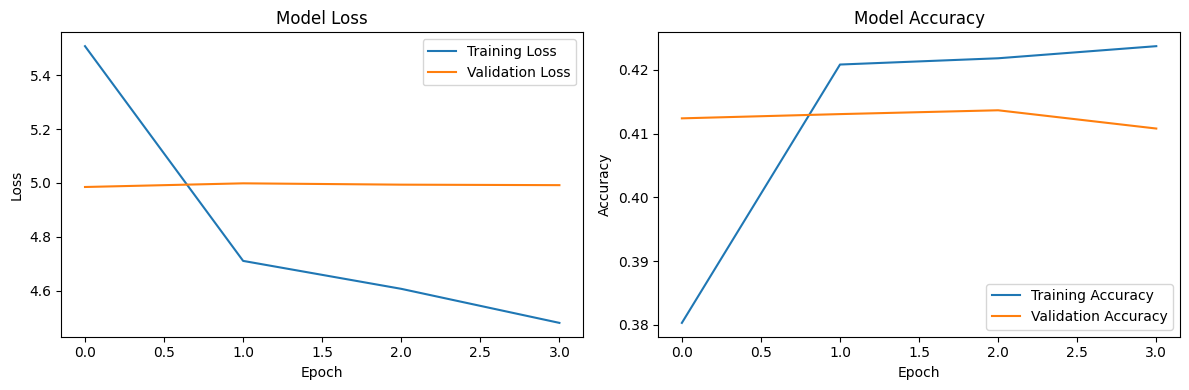

In [32]:
## Step 10: Plot Training History
import matplotlib.pyplot as plt 
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

Inference Model

In [46]:
def create_inference_models(model, encoder_vocab_size, decoder_vocab_size, 
                          encoder_max_len, decoder_max_len, hidden_units=512):

    # Encoder inference model
    encoder_model = Model(model.input[0], model.layers[4].output)  # encoder LSTM outputs
    
    # Decoder inference model
    decoder_state_input_h = Input(shape=(hidden_units,))
    decoder_state_input_c = Input(shape=(hidden_units,))
    decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
    
    decoder_inputs = Input(shape=(1,))
    decoder_embedding = model.layers[5]  # decoder embedding layer
    decoder_embedding_inf = decoder_embedding(decoder_inputs)
    
    decoder_lstm = model.layers[6]  # decoder LSTM layer
    decoder_outputs, state_h, state_c = decoder_lstm(
        decoder_embedding_inf, initial_state=decoder_states_inputs)
    decoder_states = [state_h, state_c]
    
    decoder_dense = model.layers[-1]  # output dense layer
    decoder_outputs = decoder_dense(decoder_outputs)
    
    decoder_model = Model(
        [decoder_inputs] + decoder_states_inputs,
        [decoder_outputs] + decoder_states)
    
    return encoder_model, decoder_model

In [41]:
def decode_sequence(input_seq, encoder_tokenizer, decoder_tokenizer, model, max_len):
    """
    Generate summary for a given input sequence
    """
    # Encode the input sequence
    prediction = model.predict([input_seq, np.zeros((1, max_len))])
    
    # Get the predicted sequence
    predicted_sequence = np.argmax(prediction[0], axis=-1)
    
    # Convert back to text
    decoded_sentence = ''
    for idx in predicted_sequence:
        if idx == 0:  # padding
            break
        word = decoder_tokenizer.index_word.get(idx, '')
        if word == '<end>':
            break
        if word not in ['<start>', '<OOV>']:
            decoded_sentence += word + ' '
    
    return decoded_sentence.strip()

In [42]:
def test_summarization(text, encoder_tokenizer, decoder_tokenizer, model, 
                      encoder_max_len, decoder_max_len):
    """
    Test the summarization model on a given text
    """
    # Clean and tokenize the input text
    clean_text = clean_text(text)
    input_seq = encoder_tokenizer.texts_to_sequences([clean_text])
    input_seq = pad_sequences(input_seq, maxlen=encoder_max_len, padding='post')
    
    # Generate summary
    summary = decode_sequence(input_seq, encoder_tokenizer, decoder_tokenizer, 
                            model, decoder_max_len)
    
    return summary

In [43]:
valid_indices = df[df['clean_news'].notnull() & df['clean_headline'].notnull()].index.tolist()

In [44]:
print("\n" + "="*50)
print("TESTING THE MODEL")
print("="*50)

for i in range(3):
    original_news = encoder_test[i:i+1]
    # Get the actual headline from the filtered valid indices
    actual_idx = valid_indices[len(encoder_train) + i] if len(encoder_train) + i < len(valid_indices) else valid_indices[i]
    actual_headline = df.iloc[actual_idx]['clean_headline']
    
    # Generate prediction
    predicted_headline = decode_sequence(original_news, encoder_tokenizer, 
                                       decoder_tokenizer, model, decoder_max_len)
    
    print(f"\nExample {i+1}:")
    print("-" * 30)
    print(f"Original News: {df.iloc[actual_idx]['clean_news'][:100]}...")
    print(f"Actual Headline: {actual_headline}")
    print(f"Predicted Headline: {predicted_headline}")
    print()


TESTING THE MODEL
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step

Example 1:
------------------------------
Original News: following the supreme court order striking down promotions based on reservations in the karnataka go...
Actual Headline: nearly dalit staff in karnataka govt to be demoted
Predicted Headline: to

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step

Example 2:
------------------------------
Original News: homegrown technology company smartron is set to launch an exclusive sachin tendulkarbranded mobile p...
Actual Headline: sachin tendulkarbranded phone to be launched soon reports
Predicted Headline: to

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step

Example 3:
------------------------------
Original News: actress angelina jolie and her brother james haven were seen kissing each other on the lips on the r...
Actual Headline: angelina jolie was seen kissing her brother at oscars
Predicted Headline: to

